In [1]:
%matplotlib inline
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn import decomposition, preprocessing
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import display
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
df = pd.read_csv('../datapackage/quiho/results.csv')

In [3]:
df.columns

Index(['giturl', 'commit', 'user', 'timestamp', 'benchmark', 'machine',
       'repetition', 'test', 'result'],
      dtype='object')

In [4]:
df.benchmark.unique()

array(['stressng', 'ssca', 'hpccg', 'scikit-learn', 'redisbench'], dtype=object)

In [5]:
df.test.unique()

array(['af-alg', 'atomic', 'bigheap', 'brk', 'bsearch', 'cache', 'cpu',
       'crypt', 'full', 'heapsort', 'hsearch', 'icache', 'lockbus',
       'longjmp', 'lsearch', 'malloc', 'matrix', 'memcpy', 'mincore',
       'mmap', 'mremap', 'msync', 'nop', nan, 'numa', 'oom-pipe', 'opcode',
       'qsort', 'remap', 'resources', 'rmap', 'shm', 'shm-sysv', 'stack',
       'stackmmap', 'str', 'stream', 'tsearch', 'vecmath', 'vm', 'vm-rw',
       'vm-splice', 'zero', 'ssca', 'hpccg', 'sklearn', 'SET', 'GET',
       'LPUSH', 'LPOP'], dtype=object)

In [6]:
df

,giturl,commit,user,timestamp,benchmark,machine,repetition,test,result
0,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,af-alg,7.553477e+03
1,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,atomic,6.997670e+05
2,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,bigheap,3.521001e+04
3,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,brk,6.847354e+05
4,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,bsearch,3.703138e+02
5,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,cache,3.399998e+00
6,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,cpu,2.698333e+02
7,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,crypt,1.578310e+02
8,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,full,2.808373e+05
9,git@github.com:ivotron/quiho-popper,d46d579,ivo,1512873230,stressng,c220g1.quiho.schedock-PG0.wisc.cloudlab.us,1,heapsort,4.499998e+00


In [7]:
df['machine+repetition'] = df.apply(lambda x: x['machine'] + '-' + str(x['repetition']), axis=1) 

In [8]:
len(df.index)

3043

In [9]:
df.dropna(inplace=True)

In [10]:
len(df.index)

2982

In [11]:
# pivot table to obtain features, where each microbenchmark is a feature
features = df.pivot_table(index=["machine+repetition","test"], values=['result'], fill_value=0, aggfunc=np.mean).unstack().reset_index()

In [12]:
# flatten the index
cols = features.columns.get_level_values(1).values
cols[0] = 'machine+repetition'
features.columns = cols
features.dropna(inplace=True)

In [13]:
# get features that we'll use
feature_columns = list(pd.Index(df.query('benchmark == "stressng"')['test'].unique()))

In [14]:
feature_columns

['af-alg',
 'atomic',
 'bigheap',
 'brk',
 'bsearch',
 'cache',
 'cpu',
 'crypt',
 'full',
 'heapsort',
 'hsearch',
 'icache',
 'lockbus',
 'longjmp',
 'lsearch',
 'malloc',
 'matrix',
 'memcpy',
 'mincore',
 'mmap',
 'mremap',
 'msync',
 'nop',
 'numa',
 'oom-pipe',
 'opcode',
 'qsort',
 'remap',
 'resources',
 'rmap',
 'shm',
 'shm-sysv',
 'stack',
 'stackmmap',
 'str',
 'stream',
 'tsearch',
 'vecmath',
 'vm',
 'vm-rw',
 'vm-splice',
 'zero']

In [15]:
len(feature_columns)

42

In [16]:
# what we can learn
apps = features.columns.difference(feature_columns + ['machine+repetition'])
apps

Index(['GET', 'LPOP', 'LPUSH', 'SET', 'hpccg', 'sklearn', 'ssca'], dtype='object')

In [17]:
features[feature_columns]

,af-alg,atomic,bigheap,brk,bsearch,cache,cpu,crypt,full,heapsort,...,stack,stackmmap,str,stream,tsearch,vecmath,vm,vm-rw,vm-splice,zero
0,7553.476964,699767.049846,35210.011062,684735.448826,370.313794,3.399998,269.833322,157.831009,280837.319050,4.499998,...,0.0,5.397300,20955.323904,14.517656,17.756406,995.086762,34697.775954,117.267599,588011.993310,701306.704518
1,7781.799579,691836.590695,33999.916024,682041.349398,372.682371,3.600002,264.553771,161.523973,296257.696313,4.799970,...,0.0,5.598201,20968.719984,14.652581,16.786215,973.285311,34695.541978,116.854283,586556.818768,718532.440164
2,7654.659131,712211.530050,37636.623619,667473.993735,372.613969,3.599991,265.507952,162.699643,297467.966664,4.599998,...,0.0,5.597200,20564.082368,14.447820,16.270731,996.230264,34701.876453,118.142747,598837.814568,715842.974215
3,7576.272619,698310.778376,36081.440609,690984.701922,372.592218,3.799984,276.980486,159.492281,309012.419755,4.599994,...,0.0,5.696730,21182.455044,14.314298,18.046983,970.776508,34703.410879,117.338797,606701.865304,693842.364086
4,7531.099951,684369.001130,34759.942609,694266.818332,358.423048,3.899979,263.903257,160.624668,273255.221193,4.699987,...,0.0,5.497121,20650.348687,14.811781,16.863218,996.597006,34701.328948,117.013256,603501.240285,724968.391488
5,7835.013335,687027.076900,36934.283293,701044.051951,372.575226,3.899998,265.577189,152.935049,304679.107067,4.600009,...,0.0,5.598216,20677.093173,14.201360,16.670087,1004.533012,34702.745229,119.048118,594216.428401,692966.676487
6,11119.491584,566815.710868,11945.623346,279372.101247,320.867621,3.799998,201.868509,105.625015,194135.223026,3.398779,...,0.0,173.853804,16261.965942,10.608002,15.068510,877.780328,31415.442044,128.789904,512002.676568,586474.011377
7,11023.967364,561608.733555,10985.161850,221384.126633,315.068892,4.100000,197.601607,104.149479,153795.899679,3.699906,...,0.0,138.614289,16346.893148,11.863663,15.068529,877.302445,31390.298496,147.249537,518529.360715,588227.902445
8,10939.796147,560050.729023,10511.676989,239887.563793,317.727533,3.900000,198.788331,105.544738,190965.732698,3.699875,...,0.0,174.942951,16296.135208,12.694215,14.796761,865.246798,31405.162042,142.679413,513604.620434,593552.285896
9,7734.249783,452897.790114,28385.389288,508394.555207,251.252341,3.100000,175.847631,106.680136,149373.322669,2.899985,...,0.0,3.797076,12709.650908,6.002785,11.434522,713.082115,31202.329376,103.114643,412572.826266,429844.312046


In [18]:
def plot_corrmatrix(dataf):
    corrmatrix = dataf.corr()
    mask = np.zeros_like(corrmatrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corrmatrix, mask=mask,
                xticklabels=corrmatrix.columns.values,
                yticklabels=corrmatrix.columns.values)
    return corrmatrix

In [19]:
features[feature_columns]

,af-alg,atomic,bigheap,brk,bsearch,cache,cpu,crypt,full,heapsort,...,stack,stackmmap,str,stream,tsearch,vecmath,vm,vm-rw,vm-splice,zero
0,7553.476964,699767.049846,35210.011062,684735.448826,370.313794,3.399998,269.833322,157.831009,280837.319050,4.499998,...,0.0,5.397300,20955.323904,14.517656,17.756406,995.086762,34697.775954,117.267599,588011.993310,701306.704518
1,7781.799579,691836.590695,33999.916024,682041.349398,372.682371,3.600002,264.553771,161.523973,296257.696313,4.799970,...,0.0,5.598201,20968.719984,14.652581,16.786215,973.285311,34695.541978,116.854283,586556.818768,718532.440164
2,7654.659131,712211.530050,37636.623619,667473.993735,372.613969,3.599991,265.507952,162.699643,297467.966664,4.599998,...,0.0,5.597200,20564.082368,14.447820,16.270731,996.230264,34701.876453,118.142747,598837.814568,715842.974215
3,7576.272619,698310.778376,36081.440609,690984.701922,372.592218,3.799984,276.980486,159.492281,309012.419755,4.599994,...,0.0,5.696730,21182.455044,14.314298,18.046983,970.776508,34703.410879,117.338797,606701.865304,693842.364086
4,7531.099951,684369.001130,34759.942609,694266.818332,358.423048,3.899979,263.903257,160.624668,273255.221193,4.699987,...,0.0,5.497121,20650.348687,14.811781,16.863218,996.597006,34701.328948,117.013256,603501.240285,724968.391488
5,7835.013335,687027.076900,36934.283293,701044.051951,372.575226,3.899998,265.577189,152.935049,304679.107067,4.600009,...,0.0,5.598216,20677.093173,14.201360,16.670087,1004.533012,34702.745229,119.048118,594216.428401,692966.676487
6,11119.491584,566815.710868,11945.623346,279372.101247,320.867621,3.799998,201.868509,105.625015,194135.223026,3.398779,...,0.0,173.853804,16261.965942,10.608002,15.068510,877.780328,31415.442044,128.789904,512002.676568,586474.011377
7,11023.967364,561608.733555,10985.161850,221384.126633,315.068892,4.100000,197.601607,104.149479,153795.899679,3.699906,...,0.0,138.614289,16346.893148,11.863663,15.068529,877.302445,31390.298496,147.249537,518529.360715,588227.902445
8,10939.796147,560050.729023,10511.676989,239887.563793,317.727533,3.900000,198.788331,105.544738,190965.732698,3.699875,...,0.0,174.942951,16296.135208,12.694215,14.796761,865.246798,31405.162042,142.679413,513604.620434,593552.285896
9,7734.249783,452897.790114,28385.389288,508394.555207,251.252341,3.100000,175.847631,106.680136,149373.322669,2.899985,...,0.0,3.797076,12709.650908,6.002785,11.434522,713.082115,31202.329376,103.114643,412572.826266,429844.312046


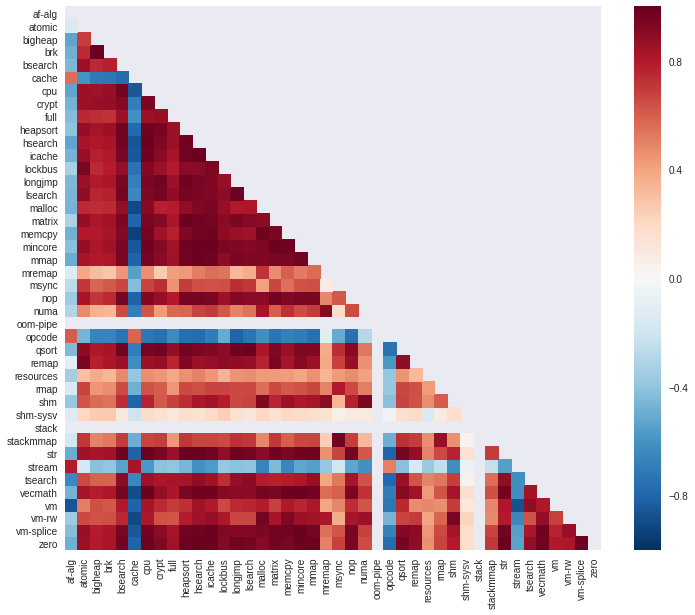

In [20]:
# plot correlation matrix for all stressors
corrmatrix = plot_corrmatrix(features[feature_columns])
plt.savefig('figures/corrmatrix.png', dpi=300, bbox_inches='tight')

In [21]:
["{} = {}".format(i, np.mean(np.abs(corrmatrix[i])) < .5) for i in corrmatrix.columns]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in absolute
  """Entry point for launching an IPython kernel.


['af-alg = True',
 'atomic = False',
 'bigheap = False',
 'brk = False',
 'bsearch = False',
 'cache = False',
 'cpu = False',
 'crypt = False',
 'full = False',
 'heapsort = False',
 'hsearch = False',
 'icache = False',
 'lockbus = False',
 'longjmp = False',
 'lsearch = False',
 'malloc = False',
 'matrix = False',
 'memcpy = False',
 'mincore = False',
 'mmap = False',
 'mremap = True',
 'msync = False',
 'nop = False',
 'numa = False',
 'oom-pipe = False',
 'opcode = False',
 'qsort = False',
 'remap = False',
 'resources = True',
 'rmap = False',
 'shm = False',
 'shm-sysv = True',
 'stack = False',
 'stackmmap = False',
 'str = False',
 'stream = True',
 'tsearch = False',
 'vecmath = False',
 'vm = False',
 'vm-rw = False',
 'vm-splice = False',
 'zero = False']

In [22]:
cpu_stressors = ['af-alg', 'atomic', 'bsearch', 'context', 'cpu', 'cpu-online', 'crypt', 'fp-error', 'getrandom', 'heapsort', 'hsearch', 'longjmp', 'lsearch', 'matrix', 'mergesort', 'nop', 'numa', 'opcode', 'qsort', 'rdrand', 'str', 'stream', 'tsc', 'tsearch', 'vecmath', 'wcs', 'zlib']
memory_stressors = ['atomic', 'bsearch', 'context', 'full', 'heapsort', 'hsearch', 'lockbus', 'lsearch', 'malloc', 'matrix', 'membarrier', 'memcpy', 'memfd', 'mergesort', 'mincore', 'null', 'numa', 'oom-pipe', 'pipe', 'qsort', 'remap', 'resources', 'rmap', 'stack', 'stackmmap', 'str', 'stream', 'tlb-shootdown', 'tmpfs', 'tsearch', 'vm', 'vm-rw', 'wcs', 'zero', 'zlib']
vm_stressors = ['bigheap', 'brk', 'madvise', 'malloc', 'mlock', 'mmap', 'mmapfork', 'mmapmany', 'mremap', 'msync', 'shm', 'shm-sysv', 'stack', 'stackmmap', 'tmpfs', 'userfaultfd', 'vm', 'vm-rw', 'vm-splice']

In [23]:
rs = np.random.RandomState(1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(features[feature_columns])

In [24]:
dff = pd.DataFrame(z_data, columns=feature_columns)

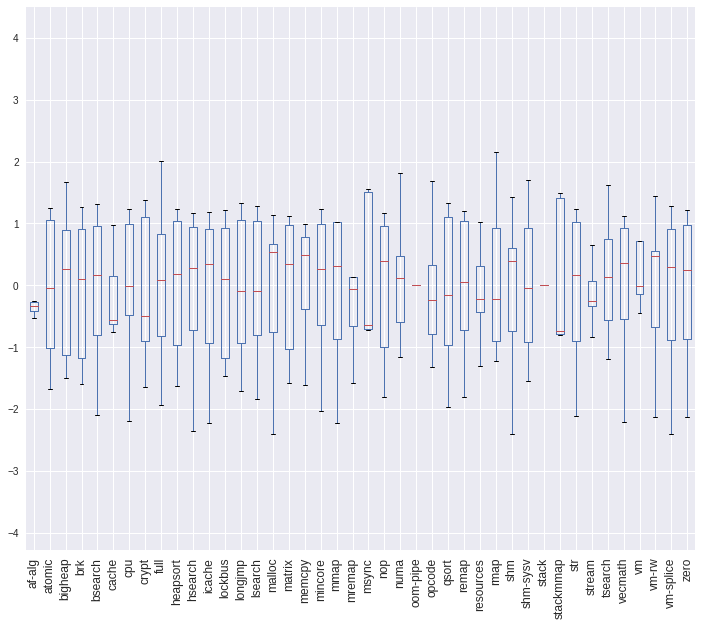

In [25]:
dff.boxplot()
_ = plt.xticks(rotation=90)
plt.savefig('figures/stressng_variability.png', dpi=300, bbox_inches='tight')

In [26]:
# gradient boosting regression
# taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
# extended to normalize data

rs = np.random.RandomState(1)
z_scaler = StandardScaler()

def plot_importance(data, feats, apps):
    for b in apps:
        # normalize data
        z_data = z_scaler.fit_transform(data[feats])
        
        # fit using random forest regressor
        params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
                  'learning_rate': 0.01, 'loss': 'ls'}
        regr = GradientBoostingRegressor(**params)
        regr.fit(z_data, data[b])

        # Plot feature importance
        feature_importance = regr.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, np.array(feats)[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title(b)
        plt.show()
        plt.savefig('figures/{}.png'.format(b), dpi=300, bbox_inches='tight')

        # print aggregate importance for each class
        importances = pd.DataFrame({'feature':feats,'importance':np.round(feature_importance,3)})
        print('CPU: {}'.format(importances.sort_values(by='importance', ascending=False).query('feature in @cpu_stressors')['importance'].values[0]))
        print('MEM: {}'.format(importances.sort_values(by='importance', ascending=False).query('feature in @memory_stressors')['importance'].values[0]))
        print('VM: {}'.format(importances.sort_values(by='importance', ascending=False).query('feature in @vm_stressors')['importance'].values[0]))
        print('')

In [27]:
# taken from https://stackoverflow.com/a/5967539/389188
# {
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]
# }

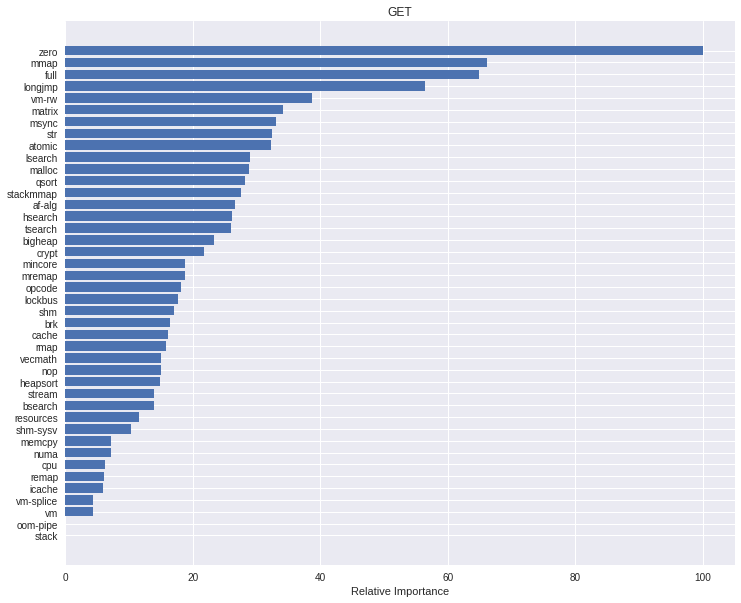

CPU: 56.511
MEM: 100.0
VM: 66.208



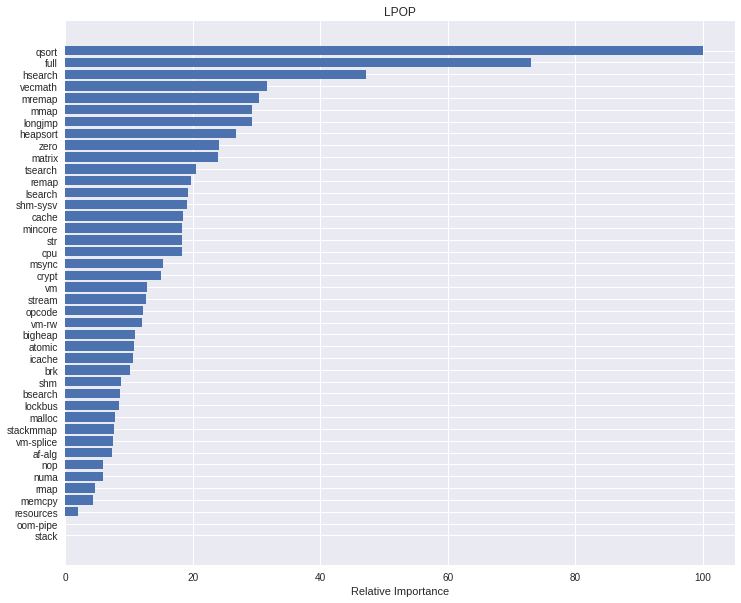

CPU: 100.0
MEM: 100.0
VM: 30.484



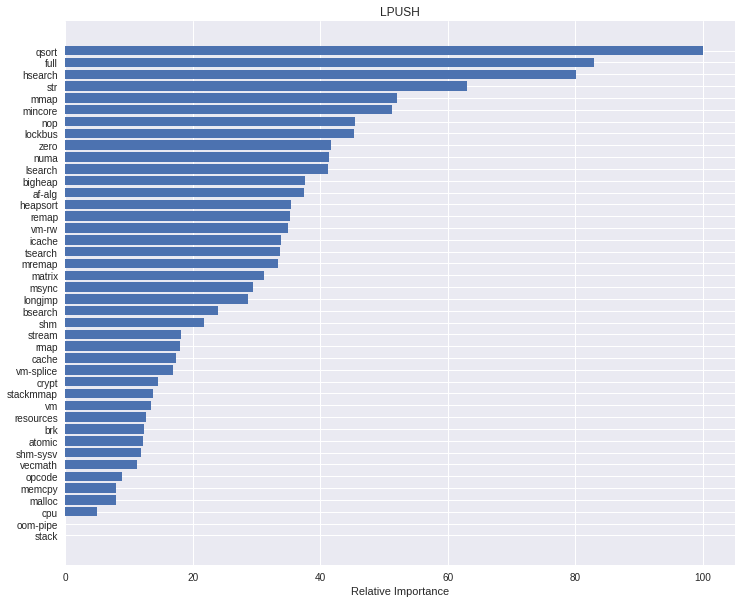

CPU: 100.0
MEM: 100.0
VM: 52.014



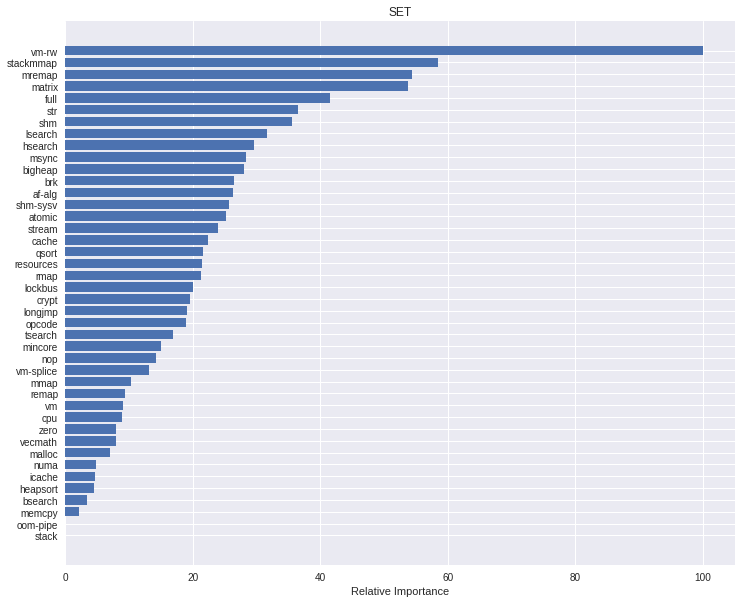

CPU: 53.714
MEM: 100.0
VM: 100.0



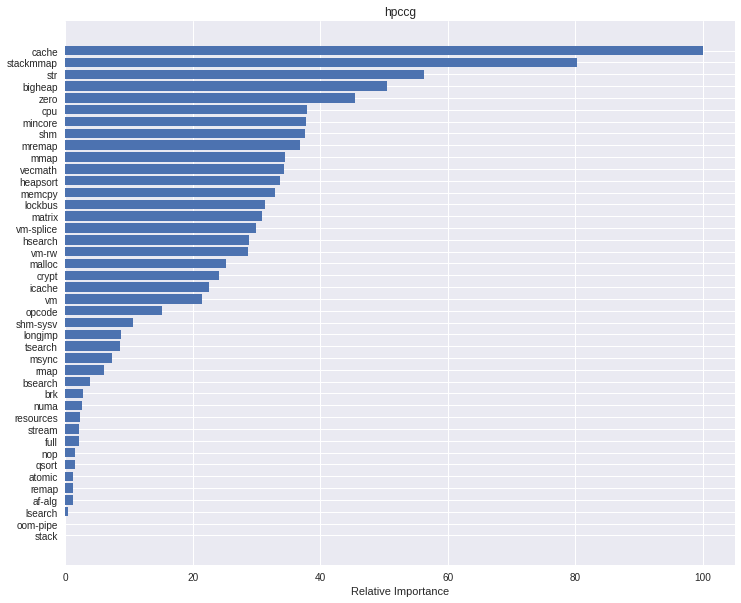

CPU: 56.268
MEM: 80.197
VM: 80.197



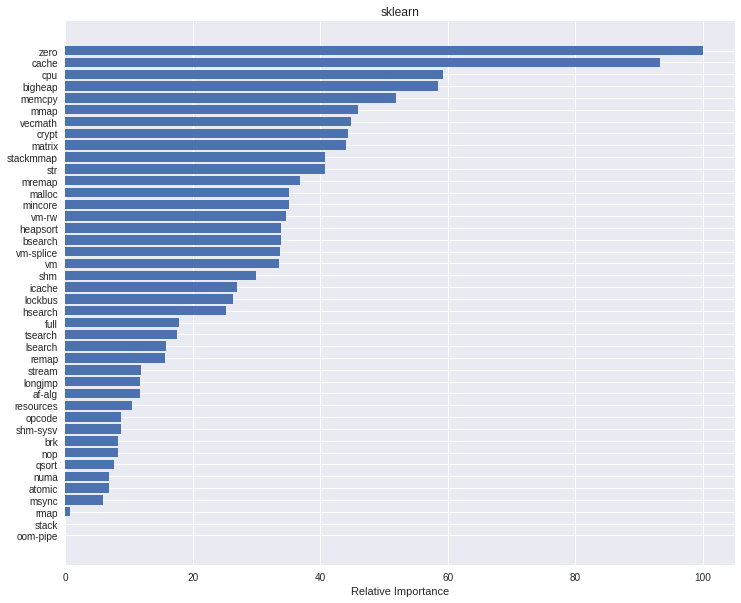

CPU: 59.273
MEM: 100.0
VM: 58.485



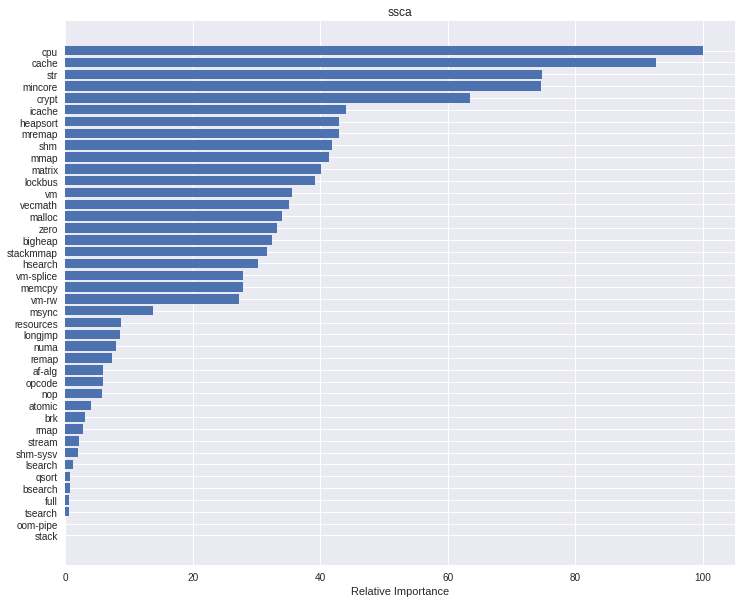

CPU: 100.0
MEM: 74.709
VM: 42.896



In [28]:
plot_importance(features, feature_columns, apps)